# Lab 4 - Text Sentiment Analysis

Today's lab will be run a little differently to usual. Instead of using the notebook to interact with Python, we'll separate our code into a number of files - closer to how a real-life project would be structured.

To facilitate this via Colaboratory, we have to mount our Google Drive storage to the notebook so we can use it like a regular file system. Once we're through these preliminary steps, we'll move on to completing a fully functional code-base which allows us to train models, then save and load them to disk for later usage.

<font color="red">If you shut down the notebook or your session times out, you will need to run the code cells in order again to connect your Google Drive storage and install the lab dependancies.</font>


We'll demonstrate this with a text sentiment task - classifying a piece of text as either positive or negative in sentiment.

For example:
 * "I hated this movie" - negative.
 * "The best pasta has lots of cheese" - positive.

The dataset we'll use is Kaggle's [Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news), which consists of financial headlines and a score of `0` or `1` for negative and positive sentiment, respectively.

Before we can get into that, we need to take care of the Colaboratory environment.

## Mount Your Google Drive Storage

Colaboratory provides the ability to mount Google Drive storage for access from within the session.

First up, run the next cell and follow the instructions to give Colaboratory access to your Google Drive. Don't worry - you're still responsible for what happens to your files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
# By default we'll assume that GPU acceleration isn't available
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Once you've authorised Colaboratory, open the Files tab 📁 on the left and navigate to the directory for this lab. Then, right click on it and select "copy path".


<font color="red">In the next cell, paste the path to your directory.</font>

_The path should look like `/content/drive/My_Drive/...`_

In [ ]:
import os
lab_dir = "TODO: PASTE THE COPIED PATH HERE"


Now we'll navigate to that directory and print out the files to check that we're in the right place.

<font color="red">Run the next cell and confirm that you see the files you uploaded for this lab.</font>

_If you don't see the lab files, you're in the wrong directory - try finding and copying the path again._

In [ ]:
# Change Python's current working directory
os.chdir(lab_dir)
# Print the name and contents of the current working directory
!pwd
!ls -al

Did you notice the exclamation mark at the start of some of the lines in the previous cell? This is a special ability of notebooks, which means that the line is interpreted as a Unix shell command instead of Python.

This is important for us, as it's how we'll be running our scripts "from the command line".

Lastly, run the following cell to enable "hot reloading" of imports - this allows us to modify files outside of the notebook and instantly use the changes here.

_The `%` character runs a notebook special command - don't worry too much about how they work._

In [ ]:
%load_ext autoreload
%autoreload 2

## Install Dependencies

When working on a real project, it's important that you keep track of the project dependencies. Python makes it quite easy if we install packages using [pip](https://pypi.org/project/pip/).

To maintain our dependencies, we keep a file called `requirements.txt`, which is a list of the Python packages along with their version numbers. Then all we need to do is run the below command to install the correct versions.

<font color="red">Navigate to the lab directory in the sidebar and double-click `requirements.txt`. Look at its contents so you know what you're about to install.</font>

Then, <font color="red">run the next cell to install the listed dependencies.</font>

_See the exclamation mark? We're not calling a Python function, we're running an entirely different process from the Linux shell._

In [ ]:
!pip install -qr requirements.txt

     |████████████████████████████████| 1.3 MB 5.5 MB/s 
     |████████████████████████████████| 1.7 MB 30.9 MB/s 
     |████████████████████████████████| 397 kB 45.8 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
     |████████████████████████████████| 2.9 MB 33.3 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 144 kB 45.4 MB/s 
     |████████████████████████████████| 181 kB 37.1 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


## Download the Dataset

As mentioned in the intro, we'll work with a financial text sentiment dataset for this lab. We'll now download the dataset and take a look at a few examples. The dataset will be downloaded and stored in your Google Drive, so we only need to download it once.

<font color="red">Run the next cell to download and unzip the dataset.</font>

In [ ]:
!wget https://ashwhall.github.io/download/financial-news/dataset.zip
!mkdir -p dataset
!unzip -qu dataset.zip -d dataset
!rm dataset.zip

--2022-04-01 04:01:55--  https://ashwhall.github.io/download/financial-news/dataset.zip
Resolving ashwhall.github.io (ashwhall.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to ashwhall.github.io (ashwhall.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93330 (91K) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  91.14K  --.-KB/s    in 0.02s   

2022-04-01 04:01:55 (5.11 MB/s) - ‘dataset.zip’ saved [93330/93330]

replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Now let's take a look at some examples. 

<font color="red">Navigate to the `dataset` directory in the sidebar, and open `train.csv`.</font>

_Recall that a label of `0` indicates negative sentiment, and a label of `1` indicates positive sentiment._

The first example talks about a company laying off tens of employees, and appropriately has a label of `0`. \
The second example talks of a new plant increasing production capacity, so has a positive label of `1`.

## Project Structure

As mentioned earlier, instead of coding in this notebook directly, we'll write our solutions in separate files. So before doing any coding, we should actually take a look at the project structure so we know how it all fits together.

<font color="red">Open the sidebar and explore some of the files in the lab directory - you should find the files that you uploaded earlier.</font>

## Write Training Code

All of our Python dependencies are installed, we have the dataset, and we roughly know how it all fits together, so now it's time to write the necessary supporting code to train models.


### Write the Dataset Class

As part of the dataset class we'll be using a tokenizer. What does a tokenizer do?
It performs the task of converting a string of text into meaningful chunks - there
are many valid ways of doing this.

For example, for the string `"Hello world!"`:
 - by character: `['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!']`
 - by word: `["hello", "world", "!"]`
 - character lookup table: `[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33]`
 - word lookup table: `[1023, 6254, 8912]`

We'll be using a pre-built word lookup table called DistilBertTokenizer.
When given a word, it returns the number that can be used to find the word embedding (vector) in the lookup table. As neural networks require numerical input, we replace every word in the
dataset with its ID, and use that as input instead.

The next cell contains example usage of the tokenizer; read and run the code with a string of your choice.

Note that we are using AutoTokenizer to create our tokenizer object. Given the name of the pretrained tokenizer, AutoTokenizer will automatically work out what type of tokenizer we want (DistilBertTokenizer in our case).

_When running this cell you may see a `wandb warning`, we'll address this a little later._

In [ ]:
# Import and initialise the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Print out the class name of our tokenizer. 
# We should see we have created an object of type DistilBertTokenizer
print(type(tokenizer).__name__)

my_string = "Hello world"
# Tokenize and print the string
output = tokenizer(my_string, truncation=True, padding=True)
print(output)

# Here we print out the tokens (word ids) separately from the 
# the attention mask.
print(output['input_ids'])
print(output['attention_mask'])

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

DistilBertTokenizer
{'input_ids': [101, 7592, 2088, 102], 'attention_mask': [1, 1, 1, 1]}


The tokenizer outputs an array of `input_ids` and an `attention_mask`, both of the same length.

Each entry in `input_ids` is the vocabulary index of the token in a lookup table containing the word embeddings (vector) representing the word, and `attention_mask` is a mechanism for handling batched inputs of varied length - which doesn't relate to this example. 

After trying a few different strings, you might notice a pattern in the input IDs - they always start and end with `101` and `102`, respectively. There are special tokens which designate the start and end of the input text - this helps the model understand the structure of the sentence.

The other IDs represent the other tokens in the sentence - it's usually one token per word, and one token for any punctuation. Try a few more inputs with punctuation and see how it affects the outputs.


<font color="red">We've seen how the tokenizer works, so now open `text_dataset.py` from the sidebar and follow the instructions to complete the code. Look for the TODO sections.</font>

Once done, run the below cell to check your solution works.

In [ ]:
# Import our class
from text_dataset import TextDataset
# Initialise
dataset = TextDataset("dataset/train.csv")
# Take out the first example
text, label = dataset[0]
# Print the contents
print("Tokens:", text)
print("Label:", label)

Tokens: tensor([  101,  1996,  2248,  4816,  3068,  2194,  3449, 19800,  4160,  2038,
         4201,  2125, 15295,  1997,  5126,  2013,  2049, 21169,  4322,  1025,
        10043,  2000,  3041,  3913, 27475,  1996,  2194, 11016,  1996,  6938,
         1997,  2049,  2436,  3667,  1010,  1996,  3679,  2695, 14428,  2229,
         2988,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Label: 0


Did it work? You should see a token tensor should half full of seemingly random numbers followed by zeros, and a label tensor with the value 0.

This is the tokenised form of the first example in the training dataset (about laying of employees), and its associated label of `0` - negative.

If not, go back to `text_dataset.py` and fix it up.

### Implement the Training Loop

The training loop code has been moved to its own file and looks similar to previous labs.

<font color="red">Open `trainer.py`, read through it to understand it. </font> The training loop for training the transformer network is pretty much the same as what we used for our computer vision labs. In this particular case we have made the code more modular by splitting the training loop into multiple nested functions.


## Train an LSTM

We'll begin with a Long Short-Term Memory model The class has already been implemented for you as it's not the focus of this lab,
but the general idea is:
 - Tokenised inputs are transformed into a learnt embedding space
 - The embeddings are passed one-at-at-time through an LSTM
 - The LSTM output for the last timestep is retained
 - This output is fed through a classifier to make class predictions

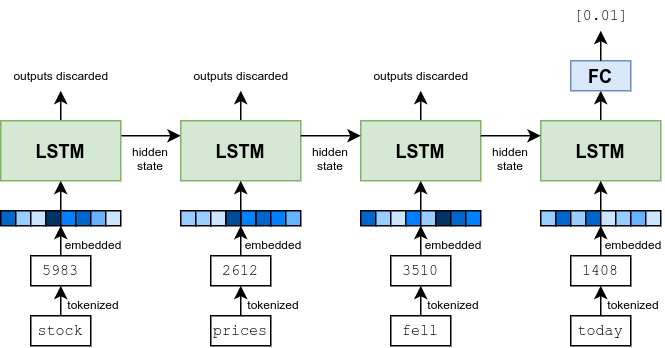

<font color="red">Open up `lstm.py` and read through it to get an idea of its implementation.</font>


We have all of the components to train a model, now we need to wire them together.

Here we first create dataset object and create model class for LSTM. Once that's done, we will train the LSTM.


In [ ]:
import trainer
import torchmetrics
from text_dataset import TextDataset
from torch.utils.data import DataLoader
from lstm import LSTM

# Seed Torch's random number generator for reproducible results
torch.manual_seed(42)

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3

# LSTM model parameters
NUM_CLASSES = 2
EMBEDDING_DIMS = 512
NUM_LAYERS = 4
HIDDEN_DIMS = 256

# TODO: Initialise two instances of TextDataset - one each for train and test.
# Read the implementation in text_dataset.py if you're not sure which arguments
# to provide.
# Also instantiate the train and test dataloaders.
#
# train_dataset = ...
# test_dataset = ...
# train_loader = ...
# test_loader = ...


# This code initialises an LSTM model.
model =  LSTM(NUM_CLASSES, train_dataset.vocab_size, EMBEDDING_DIMS, NUM_LAYERS, HIDDEN_DIMS)

# TODO: Initialise the Adam optimizer with learning rate set to LEARNING_RATE
# optimizer = ....


# TODO: set the loss_func to the cross entropy loss
# loss_func = ....


trainer.train_model(model, train_loader, test_loader, NUM_EPOCHS, loss_func,
                       optimizer, exp_name="LSTM")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_loss,0.03832
train_accuracy,0.98873
test_loss,0.66778
test_accuracy,0.76166
_step,24
_runtime,52
_timestamp,1648786113


train_loss,███████████████▇▆▅▄▃▂▂▂▁▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▆▆▇▇███
test_loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▁▁▁▂▁▂▂▂
test_accuracy,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▂▁▃▅▆▆█▇▇▇
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0. Train loss: 0.626,  accuracy: 0.691. Test loss: 0.727 accuracy: 0.710
Epoch: 1. Train loss: 0.622,  accuracy: 0.691. Test loss: 0.747 accuracy: 0.710
Epoch: 2. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.719 accuracy: 0.710
Epoch: 3. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.749 accuracy: 0.710
Epoch: 4. Train loss: 0.618,  accuracy: 0.695. Test loss: 0.776 accuracy: 0.710
Epoch: 5. Train loss: 0.621,  accuracy: 0.691. Test loss: 0.740 accuracy: 0.710
Epoch: 6. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.746 accuracy: 0.710
Epoch: 7. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.760 accuracy: 0.710
Epoch: 8. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.730 accuracy: 0.710
Epoch: 9. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.727 accuracy: 0.710
Epoch: 10. Train loss: 0.622,  accuracy: 0.691. Test loss: 0.757 accuracy: 0.710
Epoch: 11. Train loss: 0.618,  accuracy: 0.691. Test loss: 0.757 accuracy: 0.710
Epoch: 12. Train loss: 0.620,  accurac

### Visualise Training
In this lab instead of using Tensorboard or writing our own graph functions, we'll take a different route - [Weights & Biases](https://www.wandb.com/).

Weights & Biases is a web app which provides some very useful visualisation and monitoring features for training neural networks. It allows us to monitor training in real-time via the internet, and can even send you an email if your training has finished or crashed! It's quite a bit easier to use than Tensorboard, largely because you don't need to manage the logs or the Tensorboard server yourself.

It requires a free account, so we'll go through that process now.

If you looked through the `requirements.txt` at the start of the lab, you might have noticed a package called `wandb` - this is the Weights & Biases logging tool. To use it, we just initialise a session, then send it data.

<font color="red">Perform the two below steps in `trainer.py`.</font> \

__Initialise a session__: \

Uncomment the call to `wandb.init` at the start of the train_model function. The function has two arguments:
 * `project`: A distinct name for this project - something like `CSE5DL Transformers Lab`.
 * `name`: The name of the model - something like `LSTM`.

__Log data__: \
Uncomment the call to `wandb.log` in `train_model`, there we provide a `dict` of the results we want to log. You can see the following keys are used:
 * `train_epoch_loss`
 * `train_epoch_accuracy`
 * `test_epoch_loss`
 * `test_epoch_accuracy`

That's all it takes! * `Re-run the LSTM model using the cell above`, this time logging results to W&B.

<font color="red"> Re-train the model, and follow the instructions to create a W&B account</font>

_You will be prompted to create or use an existing Weights and Biases account. If you haven't yet created your account, enter option 1 and follow the instructions. Otherwise, choose option 2 to authorise this notebook. If the authorisation link doesn't appear below, open [this link](https://wandb.ai/authorize) in a new tab_

This time when you trained it, you should see a collection of miniature graphs and a link to `wandb.ai`. Visit the link to see your training graphs. 

Explore the tabs on the left side to see what information is saved with each W&B training run. You should see interesting details like GPU utilisation, output logs, and even the operating system version.

Taking a moment to interpret the results, something should look a little off. The training loss and accuracy graphs descend and ascend as we would hope, but the the test loss bounces around quite wildly and the test accuracy doesn't really improve much throughout training. This is an indicator of overfitting, and is actually a problem with using LSTMs.

Although it is possible to pre-train an LSTM on a source task and transfer the weights to a new task, for NLP it is generally found that performing transfer learning on pre-trained LSTM's do not work as well as transfer learning with transformer networks. Due to this, we won't spend any more time on LSTMs in this lab, and will move on to transformers.

If you run the LSTM twice you will get two experiments called LSTM. You can always rename any experiment by pressing on the three vertical dots next to the experiment name. For example if you changed the learning rate to something else you can add that to the name.


## Train a Transformer

The focus of this lab is on transformer models, which have overtaken LSTMs in both performance and practicality, as it's quite easy to fine-tune a transformer model on a new task.

This is exactly what we'll do now - we'll download a pre-trained transformer from [HuggingFace](https://huggingface.co/) and train it on our dataset. As the implementation is already written, we won't need to write the model ourselves.

Our chosen model is called DistilBert, which is a smaller version of the popular [Bert](https://en.wikipedia.org/wiki/BERT_(language_model)) model. There are a number of checkpoints available for us to load which can be found [here](https://huggingface.co/transformers/pretrained_models.html). We will use "`distilbert-base-uncased`" as it offers good performance with the least parameters.



First fill in the code model code in the `distbert.py` file.  Once that's done, we will train the transformer model! While it's training, return to the W&B webapp and click "runs" on the top bar - you should see live results for the transformer training.

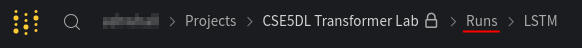

In [ ]:
from transformers import AutoModelForSequenceClassification
import utils
from distbert import DistBert

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

#TODO: Go to the distbert.py file to fill in the code for creating the 
#      "distilbert-base-uncased" model.

model = DistBert(device)

# TODO: Initialise the Adam optimizer with learning rate set to LEARNING_RATE
# optimizer = ....

# TODO: set the loss_func to the cross entropy loss
# loss_func = ....

trainer.train_model(model, train_loader, test_loader, NUM_EPOCHS, loss_func,
                       optimizer, exp_name = "Transformer")

# TODO: uncomment this line when you want to save the model        
# utils.save_model_state(model, "Transformer")

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

train_loss,0.00366
train_accuracy,0.99944
test_loss,1.06981
test_accuracy,0.79275
_step,39
_runtime,85
_timestamp,1648786220


train_loss,███████████████▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▆▇▇▇█████████████████
test_loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▁▁▁▂▁▂▂▂▃▂▃▂▃▂▃▃▃▄▄▄▄▄▄
test_accuracy,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▂▁▃▄▅▅▇▆▆▆▆▇▆█▆████▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0. Train loss: 0.344,  accuracy: 0.844. Test loss: 0.199 accuracy: 0.943
Epoch: 1. Train loss: 0.121,  accuracy: 0.959. Test loss: 0.434 accuracy: 0.959
Epoch: 2. Train loss: 0.064,  accuracy: 0.977. Test loss: 0.073 accuracy: 0.979
Epoch: 3. Train loss: 0.024,  accuracy: 0.992. Test loss: 0.091 accuracy: 0.969
Epoch: 4. Train loss: 0.025,  accuracy: 0.989. Test loss: 0.087 accuracy: 0.969
Epoch: 5. Train loss: 0.035,  accuracy: 0.985. Test loss: 0.081 accuracy: 0.974
Epoch: 6. Train loss: 0.017,  accuracy: 0.994. Test loss: 1.568 accuracy: 0.943
Epoch: 7. Train loss: 0.014,  accuracy: 0.995. Test loss: 1.239 accuracy: 0.953
Epoch: 8. Train loss: 0.010,  accuracy: 0.997. Test loss: 0.758 accuracy: 0.964
Epoch: 9. Train loss: 0.024,  accuracy: 0.993. Test loss: 0.518 accuracy: 0.943
Model state saved to model_weights/Transformer.pth


### Save Model Weights

Training is usually slow and computationally expensive, so we would like to save the model weights to disk for long-term storage. This way, we can load and re-use the weights at a later stage without the need to re-train the model.

<font color="red">Open `utils.py` and implement the incomplete saving and loading functions.</font>

Now let's use the save function at the end of training the transformer so our weights are persisted to disk.

<font color="red">Go to the previous cell and uncomment the utils.save_model_state ... line and run the cell again to train and save the model.</font>

Once training has completed, open the file sidebar and check the `model_weights` directory - you should find your model weights file.

### Load and Use the Model

What good is saving a model to disk if you don't use it?

The next cell contains some code for loading the model and classifying your custom input. See how easy it is to load the model once we have our utility function?

<font color="red">Read through the code in the next cell and run it.</font>



In [ ]:
import torch
import utils
from distbert import DistBert

# Load the model from huggingface
device = utils.get_training_device()
model = DistBert(device)

# Load model weights from disk
utils.load_model_state(model, "Transformer")

# Initialise a tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_sentiment(input_str):
    # Tokenize the given string
    encodings = tokenizer(input_str, truncation=True, padding=True)
    # Make tensor on the device
    inputs = torch.tensor(encodings["input_ids"], device=device)
    # Add batch dimension
    inputs = inputs.unsqueeze(0)

    # Get model predictions
    outputs = model(inputs)
    # Convert to a value of 0 or 1 (for negative/positive sentiment)
    sentiment = torch.argmax(outputs, -1)
    # Take only the first prediction (as we have a batch size of 1)
    sentiment = sentiment[0]

    return "Positive" if sentiment == 1 else "Negative"

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Model state loaded from model_weights/Transformer.pth


Let's try it out! Make up some financial news headlines and see what the model has to say. It won't be perfect, but it should be quite good. 

In [ ]:
my_input_string = "Apple stocks plummet 2 points in a single day"
print(predict_sentiment(my_input_string))

my_input_string = "Apple shareholders excited for early product release"
print(predict_sentiment(my_input_string))

Negative
Positive


That's a wrap! This lab has a lot of content (as usual), but the best part is that we can re-use this code for many types of projects.

All that's required for a new project is a data loader, model and training script.

Soon we'll extend this codebase to also include a basic web server so we can handle requests over the internet!

*Additional Information*

Although we wrote our own training script for maximum control over the training procedure, HuggingFace provides their own trainer implementation. If you do wish to use a pre-trained transformer in the future and don't want to write so much code, you could consider using their alternative.

*This is not required for this subject.*

https://huggingface.co/transformers/custom_datasets.html#fine-tuning-with-trainer
